In [ ]:

import requests

import json
import pandas as pd

import matplotlib as plt

from datetime import datetime, timedelta

import os

from google.colab import userdata
import csv

import openai
import requests
import time
import json
from PIL import Image
from IPython.display import display

In [ ]:
!pip install mplfinance
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 889.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.3/661.3 kB 32.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.76.0
    Uninstalling openai-1.76.0:
      Successfully uninstalled openai-1.76.0


In [ ]:
!pip show openai


Name: openai
Version: 1.76.2
Summary: The official Python library for the openai API
Home-page: https://github.com/openai/openai-python
Author: 
Author-email: OpenAI <support@openai.com>
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: anyio, distro, httpx, jiter, pydantic, sniffio, tqdm, typing-extensions
Required-by: 


In [ ]:
import mplfinance as mpf # this wont be used, just added for testing candlelight charts
import pandas as pd
import json
import openai

In [ ]:
# setting-up keys and some variables
news_key = userdata.get('News')
openai.api_key = userdata.get('OPENAI_API_KEY')
PORTFOLIO_FILENAME = "portfolio.json"
# portfolio_file_id = None

In [ ]:
# Settingup the assistant name, prompt, and tools
client = openai


desired_assistant_name = "Stock Market Expert"


existing_assistants = client.beta.assistants.list()
assistant = None
for a in existing_assistants.data:
    if a.name == desired_assistant_name:
        print("Using existing assistant: " + a.name + " (ID: " + a.id )
        assistant = a
        break
    else:
        function = [{
                        "type": "function",
                        "function": {
                            "name": "getStockData",
                            "description": "Returns the latest stock price for a ticker.",
                            "parameters": {
                                "type": "object",
                                "properties": {
                                    "ticker": {
                                        "type": "string",
                                        "description": "The stock ticker (e.g. AAPL, TSLA)"
                                    }
                                },
                                "required": ["ticker"]
                            }
                        }
                    },
                    {
                                "type": "function",
                                "function": {
                                    "name": "getNewsData",
                                    "description": "Fetches the latest news summary for a company.",
                                    "parameters": {
                                        "type": "object",
                                        "properties": {
                                            "company_name": {
                                                "type": "string",
                                                "description": "The stock name (e.g., IBM, APPL)."
                                            }
                                        },
                                        "required": ["company_name"]
                                    }
                                }
                    }]
        assistant = client.beta.assistants.create(
            name="Stock Market Expert",
            instructions=(
                "You are a well-known stock market expert. You stay up-to-date with the latest news, "
                "analyze charts, run code, call functions, and help investors make smart decisions. Your each answer has a for and against arguement. "
                "You can find patterns in the charts, and predict the outcome of the stock with additional information from the news. You will need to plot the candlestick charts using basic matplotlib python library only."
                "you also have access to the user's porfolio, and suggest whether to hold/ sell/ buy the stock already in the portfolio."
                "Give probability of buy(example 10%) and hold (example 30%) and sell(example 60%)"
            ),
            model="gpt-3.5-turbo",
            metadata = {
                "can_be_used_for_file_search": "True"
            },
            tools=[
                {"type": "code_interpreter"},   # Tool 1: Python/Code Execution
                {"type": "file_search"}, # Tool 2: File Access/Search
                *function         # Tool 3: Callable Functions
            ]
        )

Using existing assistant: Stock Market Expert (ID: asst_aWo1zRwh0aljHaFQXj1fQQPa


In [ ]:
# using to delete older portfolio.json files. Because new ones kept uploading and may run out of space
def delete_old_portfolio_files(vector_store_id):
    vector_store_files = client.vector_stores.files.list(vector_store_id=vector_store_id)

    for vector_store_file in vector_store_files.data:
        file_info = client.files.retrieve(vector_store_file.id)

        if file_info.filename == "portfolio.json":
            client.vector_stores.files.delete(vector_store_id=vector_store_id, file_id=vector_store_file.id)
            print(f"Deleted old portfolio file: {vector_store_file.id}")

    print("Finished deleting old portfolio.json files.")

# the following function is to upload the latest portfolio.json to the vector storage
# also creates a new vector store if it does not exist
def updatePortfolio():

# Portfolio initialization
  portfolio = []
  # with open("portfolio.json", "a") as f:
  #     json.dump([], f)

  # Check for existing vector store with the same name
  vector_stores = client.vector_stores.list()
  print(vector_stores)
  # Search for the store by name
  vector_store_name = "Portfolio Statements"
  vector_store = None
  file_path = "portfolio.json"
  for store in vector_stores.data:
      if store.name == vector_store_name:
          print(store)
          vector_store = store
          break

  if vector_store:
      # If the vector store already exists, use it
      # get the save portfolio.json if it exists or create new ones
      # delete_old_portfolio_files(vector_store.id)
      print(f"Using existing vector store: {vector_store.name}")
      query = "portfolio"
      search_results = client.vector_stores.search(
          vector_store_id=vector_store.id,
          query=query
      )

      portfolioData = None

      # get the data
      if search_results and len(search_results.data) > 0:
          retrieved_data = search_results.data[0].content[0].text
          print(retrieved_data)
          # saved as json, empty was a keyword I was using earlier
          if "empty" in retrieved_data:
              portfolioData = []
              print("The portfolio contains 'empty'.")
          else:
              portfolioData = json.loads(retrieved_data)

              if os.path.exists(file_path):
                      # If the file exists, update it with retrieved_data
                      with open(file_path, 'r+') as f:
                          json.dump(portfolioData, f, indent=4)
                      print("Portfolio updated.")
              else:
                      # Check if the file exists
                      if not os.path.exists(file_path):
                          with open(file_path, 'w') as f:
                              json.dump(portfolioData, f, indent=4)

      else:
          file_path = 'portfolio.json'

          # Check if the file exists
          if not os.path.exists(file_path):
              with open(file_path, 'w') as f:
                  json.dump([], f, indent=4)
          print("No relevant data found in the vector store.")
# ------------------------------------------------------------------
  else:
      # If not, create a new vector store
      vector_store = client.vector_stores.create(name=vector_store_name)
      print(f"Created new vector store: {vector_store.name}")
      if not os.path.exists(file_path):
        with open(file_path, 'w') as f:
            json.dump([], f, indent=4)

  file_paths = ["portfolio.json"]
  file_streams = [open(path, "rb") for path in file_paths]
  print("Uploading new version of portfolio.txt")

  file_batch = client.vector_stores.file_batches.upload_and_poll(
      vector_store_id=vector_store.id, files=file_streams
  )
  return vector_store

  # Print the result of the upload
  print(file_batch)
  print(file_batch.file_counts)

vector_store = updatePortfolio()
print(vector_store)

SyncCursorPage[VectorStore](data=[VectorStore(id='vs_6810f77f2ba08191b953bf65f9f6a283', created_at=1745942399, file_counts=FileCounts(cancelled=0, completed=3, failed=4, in_progress=0, total=7), last_active_at=1746102785, metadata={}, name='Portfolio Statements', object='vector_store', status='completed', usage_bytes=3587, expires_after=None, expires_at=None)], has_more=False, object='list', first_id='vs_6810f77f2ba08191b953bf65f9f6a283', last_id='vs_6810f77f2ba08191b953bf65f9f6a283')
VectorStore(id='vs_6810f77f2ba08191b953bf65f9f6a283', created_at=1745942399, file_counts=FileCounts(cancelled=0, completed=3, failed=4, in_progress=0, total=7), last_active_at=1746102785, metadata={}, name='Portfolio Statements', object='vector_store', status='completed', usage_bytes=3587, expires_after=None, expires_at=None)
Using existing vector store: Portfolio Statements
[
    {
        "Company": "IBM",
        "Shares": 8,
        "Price": 217.33
    },
    {
        "Company": "AAPL",
        "Shar

In [ ]:
# updating the vector store ID to the assistant, so that the assitant can use it as attachment
assistant = client.beta.assistants.update(
  assistant_id=assistant.id,
  tool_resources={"file_search": {"vector_store_ids": [vector_store.id]}},
)

assistantID = assistant.id
print(assistantID)

asst_aWo1zRwh0aljHaFQXj1fQQPa


In [ ]:
AlphaVantage_ApiKey = userdata.get('AlphaVantage')
Company = ""

In [ ]:
# using the Alpha Vantage API for getting the daily time series data for a company. It is for the US market
# A candle bar graph will be plotted with this information
def getStockData(company):

    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=' + company + '&apikey=' + AlphaVantage_ApiKey
    r = requests.get(url)
    data = r.json()

    if "Time Series (Daily)" not in data:
        raise Exception("Error fetching stock data: " + str(data))

    stock_data = data['Time Series (Daily)']


    sorted_dates = sorted(stock_data.keys(), reverse=True)
    last_100_days = {date: stock_data[date] for date in sorted_dates[:100]}

    import json
    return json.dumps(last_100_days)

In [ ]:
import requests
import csv

# converting the stock data into a .csv so that the chart can be plotted
def getStockDataChart(company):
    url = (
        'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY'
        f'&symbol={company}&apikey={AlphaVantage_ApiKey}'
    )
    response = requests.get(url)
    data = response.json()

    if "Time Series (Daily)" not in data:
        raise ValueError(f"Unexpected response from AlphaVantage API: {data}")

    time_series = data["Time Series (Daily)"]
    sorted_dates = sorted(time_series.keys(), reverse=True)

    headers = ['date', 'open', 'high', 'low', 'close', 'volume']

    with open('stock_data.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # write headers

        for date in sorted_dates:
            row = time_series[date]
            writer.writerow([
                date,
                row['1. open'],
                row['2. high'],
                row['3. low'],
                row['4. close'],
                row['5. volume']
            ])
    file = client.files.create(
    file=open("stock_data.csv", "rb"),
    purpose='assistants'
    )
    print("CSV file created: stock_data.csv")


In [ ]:
# using the following function to get latest news data with the name of the stock as keyword

def getNewsData(keywords):
    to_date = datetime.utcnow().date().isoformat()
    from_date = (datetime.utcnow().date() - timedelta(days=5)).isoformat()
    url = 'https://newsapi.org/v2/everything?q=' + keywords + '&from=' + from_date + '&to=' + to_date + '&pageSize=' + '10' + '&apiKey=' + news_key

    response = requests.get(url).json()
    news_summary = "\n\n".join([
    f"Title: {item.get('title', 'N/A')}\n"
    f"Source: {item.get('source', {}).get('name', 'N/A')}\n"
    f"Author: {item.get('author', 'N/A')}\n"
    f"Published At: {item.get('publishedAt', 'N/A')}\n"
    f"Summary: {item.get('description', 'N/A')}\n"
    f"URL: {item.get('url', 'N/A')}"
    for item in response.get('articles', [])
])
    return news_summary

In [ ]:
# this function adds the new stock to the portfolio.json
def updatePortfolioDetailsADD(company_name, new_shares, new_price):
    #Load existing portfolio
    with open("portfolio.json", "r") as f:
        portfolio = json.load(f)

    # Find the company if it is in portfolio, and update Shares and Average Price
    found = False
    for stock in portfolio:
        if stock["Company"] == company_name:
            # Weighted average price calculation
            total_shares = stock["Shares"] + new_shares
            total_cost = (stock["Shares"] * stock["Price"]) + (new_shares * new_price)
            stock["Shares"] = total_shares
            stock["Price"] = round(total_cost / total_shares, 2)  # rounding to 2 decimals
            found = True
            break

    # If company not found, add new entry
    if not found:
        portfolio.append({
            "Company": company_name,
            "Shares": new_shares,
            "Price": new_price
        })

    # Save updated portfolio locally
    with open("portfolio.json", "w") as f:
        json.dump(portfolio, f, indent=4)

    print("Portfolio updated successfully.")


def updatePortfolioDetailsSELL(company_name, sell_shares):
    # Load existing portfolio if it exists
    with open("portfolio.json", "r") as f:
        portfolio = json.load(f)

    # Find the company and update Shares
    found = False
    for stock in portfolio:
        if stock["Company"] == company_name:
            if sell_shares > stock["Shares"]:
                print(f"Error: Cannot sell {sell_shares} shares. Only {stock['Shares']} available.")
                return
            stock["Shares"] -= sell_shares
            found = True
            break

    # Remove company if shares become 0
    portfolio = [stock for stock in portfolio if stock["Shares"] > 0]

    # Save updated portfolio locally
    with open("portfolio.json", "w") as f:
        json.dump(portfolio, f, indent=4)

    if found:
        print("Portfolio updated successfully.")
    else:
        print(f"Error: Company {company_name} not found in portfolio.")

In [ ]:
# this code is to just see the stocks availabe in the portfolio.json already and print them
# Search vector_stores for the file
query = "portfolio"
search_results = client.vector_stores.search(
    vector_store_id=vector_store.id,
    query=query
)

portfolioData = None

# get the data
if search_results and len(search_results.data) > 0:
    retrieved_data = search_results.data[0].content[0].text
    print(retrieved_data)
    # saved as json, empty was a keyword I was using earlier, now is redundant
    if "empty" in retrieved_data:
        portfolioData = []
        print("The portfolio contains 'empty'.")
    else:
        portfolioData = json.loads(retrieved_data)
        print("The portfolio does not contain 'empty'.")
else:
    print("No relevant data found in the vector store.")


[
    {
        "Company": "IBM",
        "Shares": 8,
        "Price": 217.33
    },
    {
        "Company": "AAPL",
        "Shares": 11,
        "Price": 200.0
    }
]
The portfolio does not contain 'empty'.


In [ ]:
# delete all files of files of name file_del
def deleteAllFiles(file_del):
  files = client.files.list()

# Find the file ID of the old "stock_data.csv"
  for file in files.data:
      if file.filename == file_del:
          old_file_id = file.id
          print(f"Deleting file: {file.filename} (ID: {old_file_id})")
          client.files.delete(old_file_id)
          print("File deleted.")

# deleteAllFiles("portfolio.json")

What company are you interested in?
Thread ID: thread_GZE9TGMRqvRasOARok6WPsb2
CSV file created: stock_data.csv
Deleting file: stock_data.csv (ID: file-N7uy66qkXLSiWax3h1sjr1)
File deleted.
Deleting file: stock_data.csv (ID: file-NZo8op9rTBMJyFMnobJHx3)
File deleted.
file-XtjTvpULKXk5vdcNKpkYq3
Run status: queued
Run status: in_progress
Run status: requires_action
Run status: requires_action
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run s

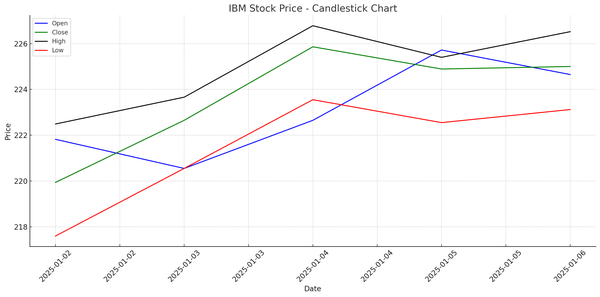

The candlestick chart for IBM stock based on the provided historical data has been plotted above. You can download the chart using the following link: [Download IBM Candlestick Chart](sandbox:/mnt/data/IBM_candlestick_chart.png).

Based on the analysis and market conditions, here is the recommendation for the IBM stock:

- **Recommendation**: **HOLD**
- **Portfolio Status**: The IBM stock is already present in the portfolio with 18 shares bought at $217.33.

### Recommendation Percentage:
- **Buy**: 20%
- **Hold**: 60%
- **Sell**: 20%

The recommendation to HOLD the IBM stock is based on the positive commitments made by the company and the overall potential for long-term growth, considering the recent news and historical stock performance. Holding the stock allows investors to benefit from future developments while monitoring the market for opportunities.

If you have any further questions or need additional analysis, feel free to ask!

What would you like to do?
1. Buy
2. Sell (if you

In [ ]:
print("What company are you interested in?")
Company = input("Stock: ")
# portfolio_file_id
thread = client.beta.threads.create()
print(f"Thread ID: {thread.id}")
chart_file = "stock_data.csv"
getStockDataChart(Company) # creates the .csv for the chart generation
deleteAllFiles(chart_file) # delete older stock files as they are old and take space

# upload new stock_data.csv
file_id = None
with open(chart_file, "rb") as f:
    chart_upload = client.files.create(file=f, purpose="assistants")
    file_id = chart_upload.id
print(file_id)



user_prompt = [
    {
        "type": "text",
        "text": (
            f"Analyze {Company} stock and decide Buy, Hold, or Sell based on latest price and news. "
            f"You have been shared a portfolio.json (use only the latest one), which may have details about older stocks already bought in the format: \n Stock: stock name \n Buy Price: price \n Stock quantity: quantity \n\n "
            f"Mention if the stock is already bought and details regarding the buy.\n\n"
            f"Decide whether to BUY (to improve average price if already bought, or just a new BUY, HOLD or SELL (Only suggest SELL if already bought and present in portfolio.json) based on current data and news. \n"
            f"Give a detailed analysis for the stock, including for and against the solution and why. \n"
            f"- Plot candlestick chart using stock_data CSV. Create the candlestick chart using the basic python matplotlib only and show the chart. Give a download link for the chart as well. This is important \n"
            f"- Detect major patterns (moving averages, RSI, MACD if you want)\n"
            f"Eg: If the company is launching a new product, and the product is highly likely to be popular, the stock price may increase in the near future.\n\n"
            f"A few things to remember: 1) the trading is for long term that is more than 1 month without selling.\n 2) The stock data will be for 100 days. \n"
            f"3) You will need to analyze data patterns by plotting candlesticks or any other chart necessary, mention any specific anomaly or pattern. \n"
            f"4) The news will help in figuring out the future of the company as well, use it to further strengthen your answer.\n\n"
            f"Give percentage of recommendation. Example Buy(90%) hold(10%) in the end. \n"
            f"Is the stock details in portfolio.json already? Show all the details in the .json file with header \n\n"
        )
    }
]
# creating the msg
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content=(user_prompt),
    attachments= [
        {
          "file_id": file_id,
          "tools": [{"type": "code_interpreter"}]
        }
      ]
)

# Step 5: Start a run
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
)

# Handle the run (including function calls and tool outputs)
while True:
    run_status = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
    print("Run status:", run_status.status)

    if run_status.status == "completed":
        break
    elif run_status.status == "requires_action":
        required_action = run_status.required_action
        tool_outputs = []

        for tool_call in required_action.submit_tool_outputs.tool_calls:
            function_name = tool_call.function.name
            arguments = json.loads(tool_call.function.arguments)

            if function_name == "getStockData": # get latest stock data
                ticker = arguments["ticker"]
                stock_price = getStockData(ticker)

                tool_outputs.append({
                    "tool_call_id": tool_call.id,
                    "output": str(stock_price)
                })
            elif function_name == "getNewsData": # get latest stock news
                ticker = arguments["company_name"]
                stockNews = getNewsData(Company)

                tool_outputs.append({
                    "tool_call_id": tool_call.id,
                    "output": str(stockNews)
                })
            else:
                print(f"Unknown function requested: {function_name}")


        run = client.beta.threads.runs.submit_tool_outputs(
            thread_id=thread.id,
            run_id=run.id,
            tool_outputs=tool_outputs
        )

    elif run_status.status in ["failed", "cancelled", "expired"]:
        print("Run failed:", run_status)
        break

    time.sleep(2)


messages = client.beta.threads.messages.list(thread_id=thread.id)

for each in messages:
  print(each)

for msg in reversed(messages.data):
    print(f"{msg.role.upper()}:")
    for block in msg.content:
        if block.type == "text":
            print(block.text.value)
        elif block.type == "image_file": # if images was created then display it
            print(f"[Image attached: file_id={block.image_file.file_id}]")
            image_data = client.files.content(block.image_file.file_id)
            image_data_bytes = image_data.read()

            with open(f"{block.image_file.file_id}.png", "wb") as file:
                file.write(image_data_bytes)
            img = Image.open(f"{block.image_file.file_id}.png")
            max_width = 600
            if img.width > max_width:
                aspect_ratio = img.height / img.width
                new_height = int(aspect_ratio * max_width)
                img = img.resize((max_width, new_height), Image.Resampling.LANCZOS)

            display(img)

        else:
            print(f"[Unhandled block type: {block.type}]")

print("\nWhat would you like to do?")
print("1. Buy")
print("2. Sell (if you already own the stock)")
print("3. Hold")

newStock = None
# below is the user inputs for BUY/SELL/HOLD
user_choice = input("Enter your choice (1/2/3): ").strip()
if user_choice == "1":
    # Buy more
    buy_more_qty = int(input("How many more shares would you like to buy? "))
    latest_price = float(input("At what price did you buy? "))
    update_prompt = (
        f"Update the portfolio based on this:\n\n"
        f"Company: {Company}\n"
        f"Bought additional shares: {buy_more_qty}\n"
        f"Purchase price per share: ${latest_price}\n\n"
        f"Update the portfolio file accordingly by adding a new entry OR adjusting the existing entry for the company.\n"
        f"After updating, reupload the file."
    )
    newStock = {
        "Company": Company,
        "Shares": buy_more_qty,
        "Price": latest_price
    }
    updatePortfolioDetailsADD(Company, buy_more_qty, latest_price)
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=update_prompt
    )
    # delete older files and replace with new ones
    delete_old_portfolio_files(vector_store.id)
    file_paths = ["portfolio.json"]
    file_streams = [open(path, "rb") for path in file_paths]
    print("Uploading new version of portfolio.json")

    file_batch = client.vector_stores.file_batches.upload_and_poll(
        vector_store_id=vector_store.id, files=file_streams
    )
    run = client.beta.threads.runs.create(
          thread_id=thread.id,
          assistant_id=assistant.id
      )

    while True:
        run_status = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        print("Update Run status:", run_status.status)

        if run_status.status == "completed":
            print("Portfolio updated!")
            break
        elif run_status.status in ["failed", "cancelled", "expired"]:
            print("Update run failed:", run_status)
            break

        time.sleep(2)

#sell
if user_choice == "2":
    sell_qty = int(input("How many shares would you like to sell? "))
    latest_price = float(input("At what price did you sell? "))
    update_prompt = (
        f"Update the portfolio based on this:\n\n"
        f"Company: {Company}\n"
        f"selling shares: {sell_qty}\n"
        f"selling price per share: ${latest_price}\n\n"
        f"Update the portfolio file accordingly by adding a new entry OR adjusting the existing entry for the company.\n"
        f"After updating, reupload the file."
    )
    # delete older files and replace with new ones
    updatePortfolioDetailsSELL(Company, sell_qty)
    file_paths = ["portfolio.json"]
    file_streams = [open(path, "rb") for path in file_paths]
    print("Uploading new version of portfolio.txt")

    file_batch = client.vector_stores.file_batches.upload_and_poll(
        vector_store_id=vector_store.id, files=file_streams
    )
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=update_prompt)

    # Step 2: Start a new run for updating
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id
    )

    # Step 3: Wait for Assistant to complete updating
    while True:
        run_status = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        print("Update Run status:", run_status.status)

        if run_status.status == "completed":
            print("Portfolio updated!")
            break
        elif run_status.status in ["failed", "cancelled", "expired"]:
            print("Update run failed:", run_status)
            break

        time.sleep(2)

# not do anything hold
else:
    print("Exiting.")